# 🌼 주가 예측 모델 만들기

---

야후 파이넌스에서 크롤링 한 데이터를 제공하는 라이브러리로서, 미국 주식부터 국내 주식의 주가 데이터를 가지고 올 수 있습니다.

실제 과거의 주식 데이터를 가지고 LSTM을 활용하여 예측하는 모델을 구현할 것입니다.

In [ ]:
# 필요 라이브러리 설치
# %pip install yfinance

  Using cached lxml-5.3.0-cp39-cp39-win_amd64.whl.metadata (3.9 kB)
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ------------------------------------- 948.2/948.2 kB 22.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
Using cached lxml-5.3.0-cp39-cp39-win_amd64.whl (3.8 MB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)
  Created wheel for peewee: filename=peewee-3.17.8-py3-none-any.whl size=139013 sha256=f8e0378c4a4ff3613ffea0929f00d11749064ac4c14a63c3d68e6aace26531ad
  Stored in directory: c:\users\rmarket\appdata\local\pip\cache\wheels\06\b3\7f\ed42a7c83ad89f578928833f57

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [2]:
# 미국 주식
apple = yf.Ticker("AAPL") # 애플
tesla = yf.Ticker("TSLA") # 테슬라
google = yf.Ticker('GOOGL') # 구글
microsoft = yf.Ticker('MSFT') # 마이크로소프트
nvidia = yf.Ticker('NVDA') # NVIDIA
netflix = yf.Ticker('NFLX') # 넷플릭스

# 국내 주식
samsung = yf.Ticker("005930.KS") # 삼성전자
hynix = yf.Ticker("000660.KS") # SK하이닉스
naver = yf.Ticker("035420.KS") # 네이버
kakao = yf.Ticker("035720.KS") # 카카오
hyundai = yf.Ticker("005380.KS") # 현대자동차
lg = yf.Ticker("066570.KS") # LG전자

period에 들어갈 수 있는 값은 "1d",  "5d",  "1mo",  "3mo",  "6mo",  "1y",  "2y",  "5y",  "10y",  "ytd",  "max" 입니다.

ytd = '올해 1월1일부터 최근 데이터'

In [3]:
# 주가 데이터 가져오기
period_data = samsung.history(period="1d")  # 지난 1년 데이터
print(period_data)

                           Open  High  Low    Close  Volume  Dividends  \
Date                                                                     
2024-11-13 00:00:00+09:00   0.0   0.0  0.0  50600.0       0        0.0   

                           Stock Splits  
Date                                     
2024-11-13 00:00:00+09:00           0.0  


- Open : 해당일 첫 번째 거래 가격

- High : 해당일 최고 거래 가격

- Low : 해당일 최저 거래 가격

- Close : 해당일 마지막 거래 가격

- Volume : 해당일 거래 주식 총 수량

In [4]:
# 주식 데이터 추출 함수
def StockData(ticker, date):
    df = ticker.history(start=date)
    df = df[['Open', 'High', 'Low', 'Volume', 'Close']] # 주가 예측에 필요없는 Dividends, Stock Splits는 제외하고 가져옵니다
    return df

In [5]:
# 삼성전자 데이터를 2023년 1월 1일부터 가져옵니다
samsung_data = StockData(samsung, "2023-01-01")

In [6]:
samsung_data

,Open,High,Low,Volume,Close
Date,,,,,
2023-01-02 00:00:00+09:00,53576.574219,54155.780427,53286.971115,10031448,53576.574219
2023-01-03 00:00:00+09:00,53480.046875,54059.253159,52611.237449,13547030,53480.046875
2023-01-04 00:00:00+09:00,53769.641605,55989.932012,53673.107239,20188071,55796.863281
2023-01-05 00:00:00+09:00,56183.007812,56762.214079,55603.801546,15682826,56183.007812
2023-01-06 00:00:00+09:00,56279.540625,57341.418750,55893.403125,17334989,56955.281250
...,...,...,...,...,...
2024-11-07 00:00:00+09:00,56900.000000,58100.000000,56800.000000,17043102,57300.000000
2024-11-08 00:00:00+09:00,58000.000000,58300.000000,57000.000000,13877396,57000.000000
2024-11-11 00:00:00+09:00,56700.000000,56800.000000,55000.000000,29811326,55000.000000


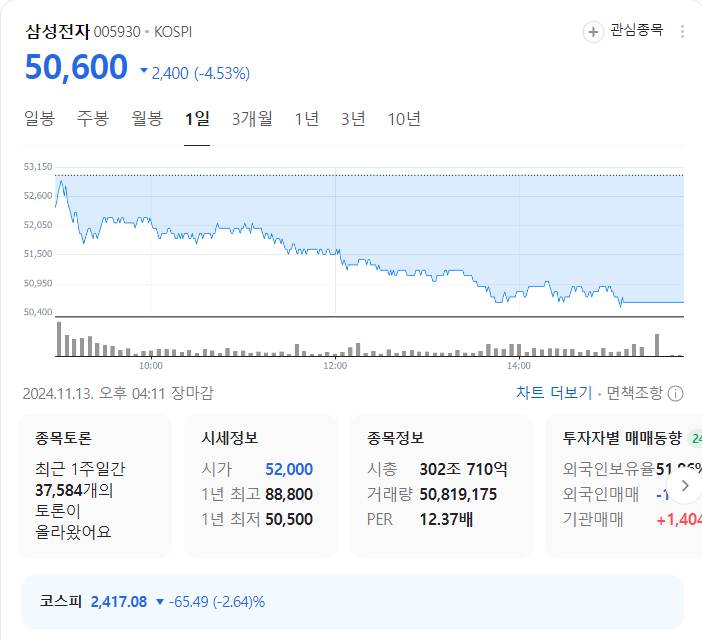

In [7]:
# 정규화 함수
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)     

In [8]:
samsung_data_x = MinMaxScaler(samsung_data) # 정규화
samsung_data_y = samsung_data_x[['Close']] # 해당일 마지막 거래 가격을 예측 할 값으로 분리

# 리스트 형태 변환
x = samsung_data_x.values.tolist()
y = samsung_data_y.values.tolist()

In [ ]:
data_x = []
data_y = []
window_size = 10     # 이전 10일 Open, High, Low, Volume, Close 데이터로 다음 날 종가 예측

for i in range(len(y) - window_size):
    x2 = x[i : i + window_size] # 10일치 데이터
    y2 = y[i + window_size] # 11일째 날 데이터
    data_x.append(x2)
    data_y.append(y2)

In [10]:
# 훈련용 데이터셋 80%
train_size = int(len(data_y) * 0.8)
train_x = np.array(data_x[0:train_size])
train_y = np.array(data_y[0:train_size])

# 테스트용 데이터셋 20%
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size:len(data_x)])
test_y = np.array(data_y[train_size:len(data_y)])

In [11]:
# 데이터 count
print(train_size)
print(test_size)

357
90


In [ ]:
model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 5), activation='relu'))
# 출력노드 20% 비활성화
model.add(Dropout(0.2))

# 두 번째 LSTM 층
model.add(LSTM(32, activation='relu'))
# 출력노드 20% 비활성화
model.add(Dropout(0.2))

# 출력층(완전 연결 구조)
model.add(Dense(1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error') # Optimizer : adam, 손실 함수:MSE
model.fit(train_x, train_y, epochs=100, batch_size=30) # epochs: 전체 데이터 학습 횟수, batch_size: 한 번에 제공되는 훈련 데이터 수
pred_y = model.predict(test_x)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1980
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0377 
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198 
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157 
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

In [13]:
# 역정규화 함수
def inverse_MinMaxScaler(normalized_data, original_data):
    original_min = np.min(original_data, 0)
    original_max = np.max(original_data, 0)
    return normalized_data * (original_max - original_min) + original_min

# 예측값과 실제값을 원래 스케일로 역변환
test_y_original = inverse_MinMaxScaler(test_y, samsung_data['Close'])
pred_y_original = inverse_MinMaxScaler(pred_y, samsung_data['Close'])

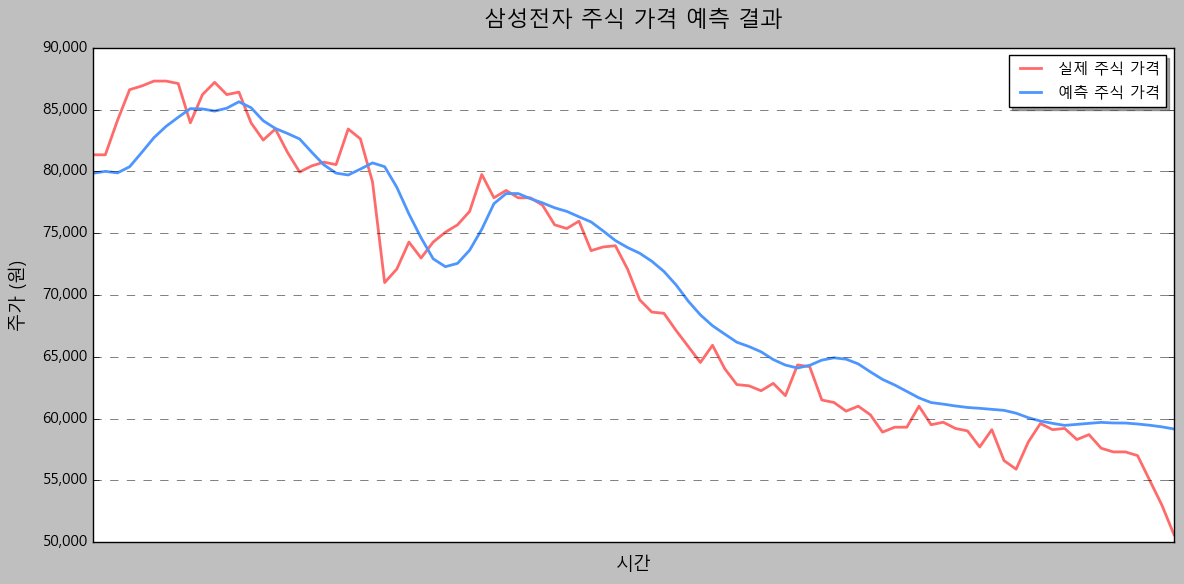

In [17]:
# 그래프 그리기
plt.style.use('classic')
plt.figure(figsize=(12, 6), dpi=100)

# 폰트 설정
plt.rc('font', family='Malgun Gothic', size=12)
plt.rc('axes', titlesize=16, labelsize=13)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)

# 데이터 플로팅
plt.plot(test_y_original, color='#FF6B6B', linewidth=2, label='실제 주식 가격')
plt.plot(pred_y_original, color='#4D96FF', linewidth=2, label='예측 주식 가격')

# 제목 및 레이블 설정
plt.title('삼성전자 주식 가격 예측 결과', pad=15)
plt.xlabel('시간', labelpad=10)
plt.ylabel('주가 (원)', labelpad=10)

# x축의 숫자 레이블 제거
plt.xticks([])

# 범례 설정
plt.legend(loc='best', frameon=True, shadow=True, fontsize=11)

# 그리드 설정
plt.grid(True, linestyle='--', alpha=0.7)

# y축 포맷 설정 (천 단위 콤마)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 여백 자동 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [18]:
# 예측 종가 계산
last_price = samsung_data.Close.iloc[-1]  # 실제 마지막 종가
predicted_value = pred_y[-1][0]  # 배열 -> 스칼라 값 변환

# 역정규화
min_price = samsung_data.Close.min()
max_price = samsung_data.Close.max()
scaling_factor = max_price - min_price

# 예측 가격 계산
predicted_price = (predicted_value * scaling_factor) + min_price

print("삼성전자 내일 마지막 거래(종가) 예측 가격 :", format(int(predicted_price), ','),"원")

삼성전자 내일 마지막 거래(종가) 예측 가격 : 59,156 원


In [29]:
predicted_value

0.2330727

### 문제

- 실제 주가 데이터와 예측 데이터를 보면 정확하게 일치하지는 않아도 비슷한 추이가 나타나는 것을 볼 수 있습니다.

- 하지만 해당 모델이 실제로 활용하기 어려운 이유가 무엇일까요?
